## Batch: run code on multiple cluster/session/animal
# This code is obsolete and has been replaced by BAtchRatBehavior

In [1]:
#modules to find path of all sessions
import glob
import os
import numpy as np
from IPython.display import clear_output, display, HTML
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
#run other notebooks

%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
#%run RunBatchRat_2_Statistics.ipynb

param={
    "goalTime":7,#needed for pavel data only
    "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
    "maxTrialDuration":20,
    "interTrialDuration":10,#None pavel
    "endTrial_frontPos":30,
    "endTrial_backPos":55, 
    "endTrial_minTimeSec":4,
    "cameraSamplingRate":25, #needed for new setup    

    "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
    "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
     "nbJumpMax":100,#200 pavel
    "binSize":0.25,
}

# 0- Functions

In [2]:
def has_tag(root, animal, session, tagList):
    """ Test if the session has at least one of the tag in tagList
    tag = empty file with a specific name, in a session folder
    """
    fullPath = os.path.join(root, animal, "Experiments", session)
    fileList = os.listdir(fullPath)
    for tag in tagList:
        if tag in fileList:
            return True
    return False

In [3]:
def compute_or_read_stats(data, saveAsPickle=True, pickleName="behaviorStats.p",redo=False):
    pathPickle=os.path.join(data.analysisPath,pickleName)
    if os.path.exists(pathPickle) and (not redo):
        with open(pathPickle,"rb") as f:
            result=pickle.load(f)
            return result    
    result={}
    
    
    
    #percentage of good trials
    result["% good trials"]=np.round(len(data.goodTrials)/float(data.nTrial) *100)
    
    #percentage of good trials in the 40 last trials
    last40GoodTrial=[trial for trial in data.goodTrials if trial>(data.nTrial-41)]
    result["% good trials on last 40"]=np.round(len(last40GoodTrial)/40.0 *100)
    
    #percentile entrance time
    entranceTimeP=np.nanpercentile(data.entranceTime,[10,25,50,75,90])
    result["percentile entrance time"]=entranceTimeP
    
    #median and std of entrance time
    result["median entrance time (sec)"]=np.nanmedian(data.entranceTime)
    result["standard deviation of entrance time"]=np.nanstd(data.entranceTime)
    result["mean entrance time (sec)"]=np.nanmean(data.entranceTime)
    
    #median correlation trajectories
    #result["median correlation of trajectories"]=plot_correlation_position(data,onlyGood=True)
    
    #correlation entrance time
    result["spearman entrance time"]=plot_correlation_entrance_time(data)

  
    #proportion of time running forward
    areaUnderCurve=plot_proportionTimeRunningForward_TrajEnd(data,binSize=1,minSpeed=-20,maxSpeed=120,smoothSpeed=0.3,onlyGood=False,highSpeed=None)
    result["time running forward"]=areaUnderCurve
    
    #proportion of time running forward for good trials
    areaUnderCurve=plot_proportionTimeRunningForward_TrajEnd(data,binSize=1,minSpeed=-20,maxSpeed=120,smoothSpeed=0.3,onlyGood=True,highSpeed=None)
    result["timerunningforwardGoodTrials"]=areaUnderCurve
    
    #Forward Speed
    result["Forward Speed"]=plot_mean_forwardSpeed(data,smoothSpeed=0.3,onlyGood=False)
    plt.close()
    
    #Forward Speed vs TreadmillSpeed
    result["Forward Speed Vs TreadmillSpeed"]=plot_mean_forwardSpeedVsTreadmillSpeed(data,smoothSpeed=0.3,onlyGood=False)
    
    #Forward Speed for good trials
    result["Forward Speed good trials"]=plot_mean_forwardSpeed(data,smoothSpeed=0.3,onlyGood=True)
    plt.close()
    
    #Tortuosity  and StraightSpeedForward
    SessionTortuosity,SessionStraightSpeed=plot_Tortuosity(data, onlyGood=False)
    plt.close()
    result["Tortuosity"]=SessionTortuosity
    result["Straight Speed Forward"]=SessionStraightSpeed
    
    #Trajectory Correlation
    SessionCorrelationTrajectory= plot_correlation_position(data,onlyGood=False,raw=False)
    plt.close()
    result["Trajectory Correlation"]=SessionCorrelationTrajectory
    
    
    
    #Trajectory Correlation for good trials
    SessionCorrelationTrajectory= plot_correlation_position(data,onlyGood=True,raw=False)
    plt.close()
    result["Trajectory Correlation good trials"]=SessionCorrelationTrajectory
    
    #Std from goaltime
    result["Std from goaltime"]=std_from_goaltime(data)
    
    
    if saveAsPickle:
        with open(pathPickle, 'wb') as f:
            pickle.dump(result, f)
    return result



def plot_learningCurves(root,animal,PerfParamToPlot,parameter={},stop_date="",tagList=[],redoPreprocess=False, redoStat=False,plot=True,PrintWarning=False):
    results={}
    days=[]
    colo=[]
    indexSession=[]
    errorSession=[]
    s=""
    for tag in tagList:
        s=s+tag  # question of david: what is this s? 
    
    
    AnimalTagPath=os.path.join(root,animal,"Tag")
    if os.path.isfile(AnimalTagPath): 
            fileTag = open(root+"/"+animal+"/Tag", "r")
            AnimalTag = fileTag.read()
    
    
    
    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/Rat*")]
    sessionList=sorted(sessionList)
    #print(sessionList)
    
    
    if stop_date!="":
        stop_session = [os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/"+animal+stop_date+"*")]
        if PrintWarning:
            print(stop_session)
        indexSession= sessionList.index(stop_session[0])
        del sessionList[indexSession:]
    
    
    res_TS =[]
    #loop through sessions
    for session in sessionList:  
        if PrintWarning:
            print("--------")
            print(session)
        if len(tagList)>0:
            if not has_tag(root, animal, session, tagList):
                    continue
        #load data for this session (add redoPreprocess=True to overwrite preprocess)
        try:
            sessionData=Data(root,animal,session,parameter,redoPreprocess=redoPreprocess)
        except Exception as e:
            if PrintWarning:
                display(HTML("<b> An error happened, skip session. Error message: </b>"))
                display(HTML("<b>"+e.__class__.__name__+": "+str(e)+"</b>"))
                print("--------")
            errorSession.append(session)
            
            continue
        #---skip if file "NotToAnalyze"
        try:
            if "NotToAnalyze" in sessionData.emptyAnalysisFiles:
                if PrintWarning:
                    print("Not to analyze, skipped")
                    print("--------")
                continue 
        except:
            continue
   
        if not sessionData.hasBehavior:
            continue
        try :
            et=sessionData.entranceTime 
        except:
            if PrintWarning:
                print('No entrance time, skipped')
                print("--------")
            continue   
        #skip if training data or no break time
        if (not sessionData.hasBehavior):
            if PrintWarning:
                print("No Behavior, skipped")
                print("--------")
            continue
        
        days.append(sessionData.daySinceStart)
        if (sessionData.hasSpike) or (glob.glob(sessionData.fullPath+".dat")):
            colo.append("red")
        else:
            colo.append("black")
        
        #Compute a bench of Performance Parameters using a dedicated function
        res=compute_or_read_stats(sessionData,redo=redoStat)
        #davdebug
        
        
        #adding treadmill speed to res
        res["treadmillSpeed"]=np.nanmedian(sessionData.treadmillSpeed)
        
        
        #adding goaltime speed to res
        res["goaltime"]=np.unique(sessionData.goalTime)
       
        
        
        if len(PerfParamToPlot)==0:
            PerfParamToPlot=list(res.keys())
            
        keys = list(res.keys())        
        for key in keys:
            try:
                results[key].append(res[key])
            except KeyError:
                results[key]=[res[key]]
                
                
    #clear_output()
    # One subplot for every key in results
    nbCol=2
    nbLine=len(PerfParamToPlot)//nbCol+len(PerfParamToPlot)%nbCol
    if plot:    
        fig=plt.figure(figsize=(15, 3*nbLine))
        #fig.subplots_adjust(hspace=1)
        for index,key in enumerate(sorted(PerfParamToPlot)):
            #print(index,key)
            ax=plt.subplot(nbLine,nbCol,index+1)
            if isinstance(results[key][0],(np.ndarray,list)):
                if key=="percentile entrance time":
                    med=[array[2] for array in results[key]]
                    lowestdist=[array[1] for array in results[key]]
                    higestdist=[array[-2] for array in results[key]]
                    lowError=[array[2]-array[1] for array in results[key]]
                    highError=[array[3]-array[2] for array in results[key]]
                    ax.errorbar(days,med,yerr=np.vstack([lowError,highError]),ls="",color='k')
                    colorNonan=[c for c,res in zip(colo,med) if not np.isnan(res)]
                    ax.scatter(days,med,c=colorNonan,zorder=10, s=20)
                    ax.plot(days,med,color="lightgrey",linewidth=2)
                    ymax=max(higestdist)
                    ymin=min(lowestdist)
                    key+=" (25% - 50% - 75%)"
                    ax.set_ylim([1,15])
                    ax.plot(days,results["goaltime"],color="red",linestyle='--')
            else:

                ax.plot(days,results[key],color="lightgrey",linewidth=2)
                colorNonan=[c for c,res in zip(colo,results[key]) if not np.isnan(res)]
                ax.scatter(days,results[key],c=colorNonan,zorder=10,s=20)
                ymax=max([x for x in results[key] if not isNone(x)])
                ymin=min([x for x in results[key] if not isNone(x)])
               
           
            ax.set_title(animal+" "+key)
            if key=="median entrance time (sec)":
                ax.set_ylim([4,10])
            if key=="treadmillSpeed":
                ax.set_ylim([0,35])
            if key=="Trajectory Correlation":
                ax.set_ylim([0,1])
            if key=="% good trials on last 40":
                ax.set_ylim([0,100])   
                plt.axhline(72.5,linestyle='--',color='red')
            if key=="Forward Speed Vs TreadmillSpeed":
                ax.set_ylim([1,5])
            if key=="Std from goaltime":
                ax.set_ylim([0,3])
            if key=="Tortuosity":
                ax.set_ylim([2,7])
                
            
            ax.set_xlabel("session day")
            ax.xaxis.grid(which='major')  

            major_ticks = np.arange(0, days[-1], 10)                                              
            minor_ticks = np.arange(0, days[-1], 2)                                               
            ax.set_xticks(major_ticks)                                                       
            #ax.set_xticks(minor_ticks, minor=True)
            ax.set_xlim([days[0]-1,days[-1]+1])
           

        plt.tight_layout()            
        plt.subplots_adjust(top=0.9)
        
        AllTreadmillSpeedsUsed=np.unique(results['treadmillSpeed'])
        SpeedInfoForTitle=''
        for TreadmillSpeedUsed in AllTreadmillSpeedsUsed:
            SpeedInfoForTitle += str(TreadmillSpeedUsed) +'-' 
            
        SpeedInfoForTitle=SpeedInfoForTitle[:-1]
        
        
        plt.suptitle(animal + ' (' + AnimalTag + '), trained at '+ SpeedInfoForTitle + 'cm/s',fontsize=16)

        #save plot
        path=os.path.join(root,animal,"Analysis")
        if not os.path.exists(path):
            os.mkdir(path)
 
        pathFig=os.path.join(path,"NewLearningAcrossSession"+s+".png")
        plt.savefig(pathFig)
    
    #save learning curve of all performance and task param in pickle 
    results["days"]=days
    # adding treadmill speed
    #results["treadmillSpeed"]=res_TS
    path=os.path.join(root,animal,"Analysis")
    if not os.path.exists(path):
            os.mkdir(path)
    path=os.path.join(path,"learningStats"+s+".p")
    

    with open(path, 'wb') as f:
        pickle.dump(results, f)
    if PrintWarning:
        print("Save pickle: %s"%path)

    if errorSession:
        if PrintWarning:
            display(HTML("<b> An error happened for the following session(s):"))
            print("\n".join(errorSession))
    return results



In [6]:
def kinematic_histo_to_compare(data,data1,kinematic="speedSmoothBin",binSize=1,onlyGood=False):
    k=np.asarray([])
    for trial in data.trials:
        if (not onlyGood) or (trial in data.goodTrials):
            k=np.append(k,data.__dict__[kinematic][trial])    
    k1=np.asarray([])
    for trial in data1.trials:
        if (not onlyGood) or (trial in data1.goodTrials):
            k1=np.append(k1,data.__dict__[kinematic][trial])     
    #check that the vector is not empty
    if len(k)==0 or len(k1)==0:
        return np.nan   
    #histogram between min and max speed, with binSize
    mink=np.min([np.nanmin(k),np.nanmin(k1)])
    maxk=np.max([np.nanmax(k),np.nanmax(k1)])
    hist,bins=np.histogram(k,np.arange(mink,maxk+1,binSize),density=True)
    hist1,bins=np.histogram(k1,np.arange(mink,maxk+1,binSize),density=True)
    return hist,hist1



def kinematic_histograms(root,animal,param={},kinematic="speedSmoothBin",binSize=1, saveAsPickle=True, pickleName="DistributionSpeed.p",onlyGood=False,redoPreprocess=False,redo=False):
    pathPickle=os.path.join(root,animal,"Analysis",pickleName)
    if os.path.exists(pathPickle) and (not redo):
        with open(pathPickle,"rb") as f:
            kinemahists=pickle.load(f)
            return kinemahists   
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/Rat*")]
    sessionList=sorted(sessionList)
    errorSession=[]
    kinemahists={}
    ks = {}
    for count, session in enumerate (sessionList):
        
        try:
            data=Data(root,animal,sessionList[count],param,redoPreprocess=redoPreprocess)
            k=[]
            for trial in data.trials:
                if (not onlyGood) or (trial in data.goodTrials):
                    k=np.append(k,data.__dict__[kinematic][trial])    
        except Exception as e:
            display(HTML("<b> An error happened, skip session. Error message: </b>"))
            display(HTML("<b>"+e.__class__.__name__+": "+str(e)+"</b>"))
            errorSession.append(session)
            print("--------")
            continue

        #check that the vector is not empty
        if len(k)!=0:
            ks[count] = k
    clear_output()
    #return ks
    mink=np.nanmin([np.nanmin(ks[i]) for i in ks])
    maxk=np.nanmax([np.nanmax(ks[i]) for i in ks])
    hists={}
    for count in ks:
    #histogram between min and max speed, with binSize
        hists[count],_=np.histogram(ks[count],np.arange(mink,maxk+1,binSize),density=True)
    print("Done")
    if errorSession:
        display(HTML("<b> An error happened for the following session(s):"))
        print("\n".join(errorSession))
    bins=np.arange(mink,maxk+1,binSize)
    kinemahists["mibins"]=bins[:-1]+np.diff(bins)/2.
    kinemahists["distribution"]=hists
    if saveAsPickle:
        with open(pathPickle, 'wb') as f:
                pickle.dump(kinemahists, f)
    #plt.plot(hists["mibins"],hists[0])
    #plt.plot(hists["mibins"],hists[1])
    return kinemahists,errorSession

#----------------------------------------------------------------------------------------------------------------------
# if "__file__" not in dir():
#     kinemahists,errorSession=kinematic_histograms(root,"Rat057",kinematic="speedSmoothBin", pickleName="DistributionSpeed.p",binSize=1,onlyGood=False)
#     plt.plot(kinemahists["mibins"],kinemahists["distribution"][0])
#     plt.plot(kinemahists["mibins"],kinemahists["distribution"][1])

In [5]:
PerfParamToPlot =["percentile entrance time","% good trials on last 40","median entrance time (sec)",
             "Trajectory Correlation","Forward Speed Vs TreadmillSpeed","Tortuosity",'Std from goaltime']

## 1 -  Fix parameters

In [12]:
if "__file__" not in dir():
    #------------------------Check Path !----------------------
    root="/data"
    redoStat_ = True
    root="/Users/davidrobbe/Documents/Data/"

## 2 -  Loop through every session of several animals

!!!! Animal in animalList should be preprocessed in Bach 1 !!!

rat statistic is going to be excuted


UnboundLocalError: local variable 'AnimalTag' referenced before assignment

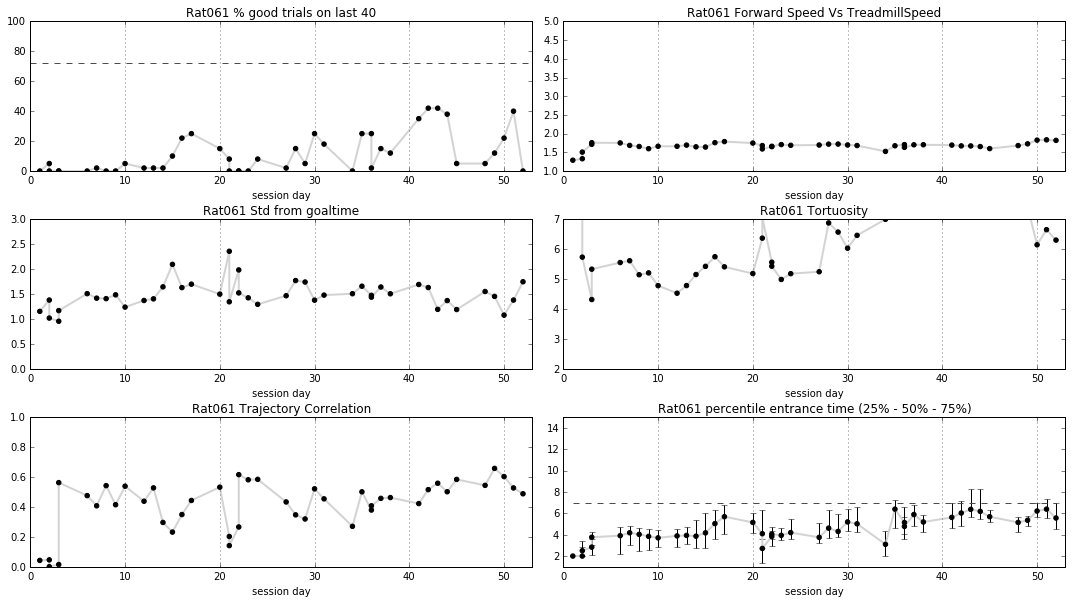

In [13]:
if "__file__" not in dir():
    #one plot per rat
    #animalList = ["Rat043","Rat044","Rat045","Rat046","Rat051","Rat056","Rat058","Rat060","Rat063","Rat066","Rat065",]
    PerfParamToPlot =["percentile entrance time","% good trials on last 40",
             "Trajectory Correlation","Forward Speed Vs TreadmillSpeed","Tortuosity",'Std from goaltime']
    animalList = ['Rat101', 'Rat102', 'Rat103', 'Rat104']
    animalList = ['Rat061']
    stop_date = ""
    errors=[]
    tagList=["BeforeBreak","AfterBreak","AfterLesion"]#,"VariableSpeed","ChangeSpeedPosition"]
    
    tagList=[]
    redoStat_ = True 
    #param={}#redo preprocess == False
    if len(tagList)>0:
        for tag in tagList:
            for animal in animalList:
            #try:
                results = plot_learningCurves(root, animal,PerfParamToPlot, param,stop_date,[tag], redoPreprocess=True, redoStat=redoStat_)
    else:
        for animal in animalList:
            #try:
            print("rat statistic is going to be excuted")
            results = plot_learningCurves(root, animal,PerfParamToPlot, param,stop_date,[], redoPreprocess=True, redoStat=True)

        
    #except Exception as e:
        #    errors.append((e, animal))
        #    continue

    #display errors
    for e, animal in errors:
        display(HTML("<b> An error happened, skip animal Error message: </b>"))
        display(HTML("<b>"+e.__class__.__name__+": "+str(e)+"</b>"))
    #--------------------------------------------------------------------------------------------------------

# Investigating Evolution of kinematics distributions



## 1. Plot evolution speed distribution across learning

Done


Rat077_2016_06_13_16_28
Rat077_2016_06_14_15_38
Rat077_2016_06_15_14_54
Rat077_2016_06_16_14_30
Rat077_2016_06_17_15_20
Rat077_2016_06_20_17_33
Rat077_2016_06_21_15_05
Rat077_2016_06_22_15_47
Rat077_2016_06_23_17_30
Rat077_2016_06_24_16_40
Rat077_2016_06_27_15_04
Rat077_2016_06_28_16_29
Rat077_2016_07_11_12_34
Rat077_2016_07_12_12_00
Rat077_2016_07_13_13_12
Rat077_2016_07_14_12_09
Rat077_2016_07_15_12_22
Rat077_2016_07_18_13_55
Rat077_2016_07_19_12_22
Rat077_2016_07_20_12_19
Rat077_2016_07_21_12_46
Rat077_2016_07_22_11_51
44
dict_keys([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])


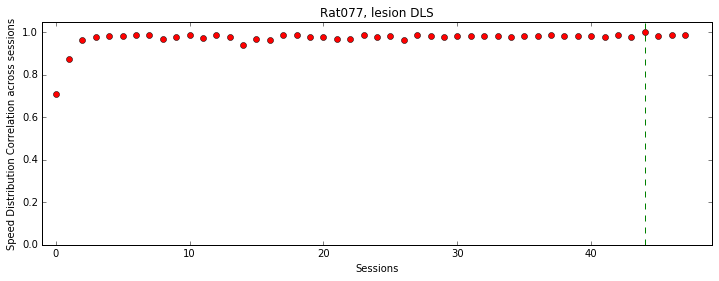

In [9]:
if "__file__" not in dir():
    animal ="Rat077"
    
    #Calculate nb surgery session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/Rat*")]
    sessionList=sorted(sessionList)
    nbSurgerySession=[]
    for count, session in enumerate (sessionList):
         if sessionList[count] == "Rat077_2016_09_28_12_24":
            nbSurgerySession=count
              
    from scipy.stats import pearsonr,ks_2samp
    kinemahists,errorSession=kinematic_histograms(root,animal,kinematic="speedSmoothBin", pickleName="DistributionSpeed.p",binSize=1,onlyGood=False,redo=True)
    if errorSession!=0:
        nbSurgerySession=nbSurgerySession-len(errorSession)
        print(nbSurgerySession)
    CorrStat,pval=[],[]
    ListKeys=sorted(list(kinemahists["distribution"].keys()))
    print(kinemahists["distribution"].keys())
    for count in ListKeys:
            try:
                corr,pcorr =pearsonr(kinemahists["distribution"][count],kinemahists["distribution"][ListKeys[nbSurgerySession]])
                #corr,pcorr =pearsonr(kinemahists["distribution"][count],kinemahists["distribution"][count+1])
            except:
                continue
            CorrStat.append(corr)
            pval.append(pcorr)
    plt.figure(figsize=(12, 4))
    l=np.arange(len(CorrStat))
    plt.axvline(nbSurgerySession, color="g",ls="--") 
    plt.ylabel("Speed Distribution Correlation across sessions")
    plt.xlabel("Sessions")
    CorrStat = np.array(CorrStat)
    pval = np.array(pval)
    #plot color value depending on the p value
    plt.plot(l[pval<=0.05],CorrStat[pval<=0.05],"ro")
    plt.plot(l[pval>0.05],CorrStat[pval>0.05],"bo") 
    plt.xlim([-1,(len(ListKeys)+1)])
    plt.ylim([0,1.05])
    plt.title(("%s, lesion DLS")%animal)
    #save figure
    path=os.path.join(root,animal,"Analysis")
    if not os.path.exists(path):
        os.mkdir(path)
    pathFig=os.path.join(path,"SpeedDistributionCorrelation.png")
    plt.savefig(pathFig)

## 2. Plot evolution acceleration distribution across learning

Done


Rat077_2016_06_13_16_28
Rat077_2016_06_14_15_38
Rat077_2016_06_15_14_54
Rat077_2016_06_16_14_30
Rat077_2016_06_17_15_20
Rat077_2016_06_20_17_33
Rat077_2016_06_21_15_05
Rat077_2016_06_22_15_47
Rat077_2016_06_23_17_30
Rat077_2016_06_24_16_40
Rat077_2016_06_27_15_04
Rat077_2016_06_28_16_29
Rat077_2016_07_11_12_34
Rat077_2016_07_12_12_00
Rat077_2016_07_13_13_12
Rat077_2016_07_14_12_09
Rat077_2016_07_15_12_22
Rat077_2016_07_18_13_55
Rat077_2016_07_19_12_22
Rat077_2016_07_20_12_19
Rat077_2016_07_21_12_46
Rat077_2016_07_22_11_51
44


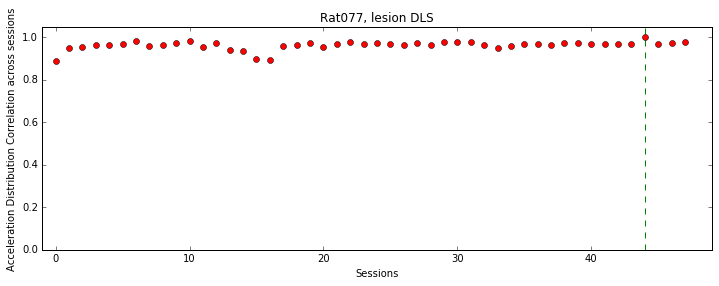

In [10]:
if "__file__" not in dir():
    animal = "Rat077"
    
    #Calculate nb surgery session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/Rat*")]
    sessionList=sorted(sessionList)
    nbSurgerySession=[]
    for count, session in enumerate (sessionList):
         if sessionList[count] == "Rat077_2016_09_28_12_24":
            nbSurgerySession=count
    
    from scipy.stats import pearsonr,ks_2samp
    kinemahists,errorSession=kinematic_histograms(root,animal,kinematic="accelerationOnSpeedSmoothBin", pickleName="DistributionAcceleration.p",binSize=1,onlyGood=False,redo=True)
    if errorSession!=0:
        nbSurgerySession=nbSurgerySession-len(errorSession)
        print(nbSurgerySession)
    CorrStat,pval=[],[]
    ListKeys=sorted(list(kinemahists["distribution"].keys()))
    for count in ListKeys:
            try:
                corr,pcorr =pearsonr(kinemahists["distribution"][count],kinemahists["distribution"][ListKeys[nbSurgerySession]])
            except:
                continue
            CorrStat.append(corr)
            pval.append(pcorr)
  
    plt.figure(figsize=(12, 4))
    l=np.arange(len(CorrStat))
    plt.axvline(nbSurgerySession, color="g",ls="--") 
    plt.ylabel("Acceleration Distribution Correlation across sessions")
    plt.xlabel("Sessions")
    CorrStat = np.array(CorrStat)
    pval = np.array(pval)
    #plot color value depending on the p value
    plt.plot(l[pval<=0.05],CorrStat[pval<=0.05],"ro")
    plt.plot(l[pval>0.05],CorrStat[pval>0.05],"bo") 
    plt.xlim([-1,(len(ListKeys)+1)])
    plt.ylim([0,1.05])
    plt.title(("%s, lesion DLS")%animal)
    #save figure
    path=os.path.join(root,animal,"Analysis")
    if not os.path.exists(path):
        os.mkdir(path)
    pathFig=os.path.join(path,"AccelerationDistributionCorrelation.png")
    plt.savefig(pathFig)